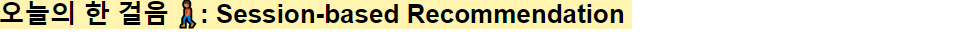

## Contexts

### 1. READY
    1-1 오늘의 Exp와 Rubric  
    1-2 사용하는 라이브러리  

### 2. GAME
    2-1. 데이터 읽어오기  
    2-2. 데이터 전처리
        -1. EDA (Exploration Data Analysis)
        -2. 전처리
        
    2-3. 모델 학습  
    2-4. 데이터 평가   

### 3. POTG (best Play Of The Game
    3-1. 소감(POTG)  
    3-2. 어려웠던 점과 극복방안  
    3-3. 추후  

---


# 1. Ready
## 1-1. 오늘의 Exp와 Rubric


우리가 가지고 있는 movielens 데이터셋을 기반으로
해당 user 의 Session Based Recommendation 영화 추천 시스템을 만들 것이다.

> Session Based Recommendation 란?  
Session 은 인터넷에서 사용자의 행동기록을 의미한다. 사용자가 로그인을 했든 하지 않았든  
그 당장의 클릭 기록이나 사이트 체류시간 등  
순간적인 기록을 이용해 추천하는 방식을 의미한다.

오늘의 rubric은 다음과 같다.

|평가문항|상세기준|
|---|---|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|



## 1-2. 사용하는 라이브러리

In [1]:
import pandas as pd
import numpy as np #데이터 배열 처리 라이브러리

from pathlib import Path
import os #데이터 경로 설정

import matplotlib.pyplot as plt #데이터 시각화

import datetime as dt #날짜 계산 라이브러리

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical #모델 생성 라이브러리

from tqdm import tqdm  #progress 생성 라이브러리


# 2. GAME
## 2-1. 데이터 읽어오기

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/workplace/E16/data/') #이미 저장해둔 영화 평 데이터
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)

data['Time'] = pd.to_datetime(data['Time'], unit='s')

data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

/opt/conda/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


데이터는 `User_id` 순으로 정렬했다.  
cloumns 는 index, 유저id, 영화id, 평가된 점수, 평가한 날짜   
총 5가지로 저장되어 있다.  

## 2-2.데이터 전처리
### 2-2-1. EDA

#### 1) 세션별 탐색

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

이용자 수는 6040명, 영화의 수는 3700개 이다.  
총 index가 100만 이었는데 이용자 6040명인걸로 보아   
평균 영화 평 횟수는 100편 정도로 예상되는데, 한번 더 자세히 살펴볼까?

In [4]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

`session_length` 는 한 user 당 몇개의 영화에 별점을 주었는지를 나타낸다.

In [5]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [6]:
session_length.min(), session_length.max()

(20, 2314)

In [7]:
session_length.quantile(0.999)

1343.181000000005

해당 데이터들은 다음과 같은 vision 을 보여준다.

1. 한 사람당 평균적으로 165개의 영화를 평했다.
2. 가장 적게 평가한 사람은 20개, 가장 많이 평가한 사람은 2300개,
3. 상위 99.9% 의 사람은 1343개의 영화를 평했다.

영화를 2300개나 본 사람은 대체 언제 이 영화들을 다 본걸까?

In [8]:
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697882,4169,3754,2,2002-06-15 20:52:27
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00
695945,4169,1804,2,2002-06-15 21:16:23


2년간 2300개의 영화에 평을 매겼다.

하루에 6편씩 영화를 본 셈인데, 12시간은 영화만 보고 있어야 한다.  
실제로 기록을 보면 동일한 시간에 5개에 대한 평가를 매기고 있다.

적어도 1년에 365개 이상의 영화를 본 사람은  
영화에 대해 건성히 본 사람, 혹은 악의적인 시도를 하는 고객이라고 판단하기로 했다.

#### 2) 시간별 탐색

추천시스템은 시간적 Trend 에도 영향을 많이 받는다.  
때문에 영화 평점 데이터도 시간이 지남에 따라 많은 변화가 있었을 것이다.  
하지만 현재 우리가 가진 가장 예전 데이터는 2000년, 가장 빠른 데이터는 2003년이므로  
큰 편차가 없을 것으로 판단했다.

In [9]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [10]:
diff = latest -  oldest
diff

Timedelta('1038 days 18:44:18')

총 1038 일이다.

어느정도 데이터를 정리했으니
정확한 추천이 이루어질 수 있도록 데이터를 정제하도록 한다.

1. 평점 매긴 횟수가 너무 적은 사람들을 제거한다
2. 평점을 너무 많이 매긴 사람들을 제거한다.

3. 평점이 너무 안매겨진 영화는 제거한다.


## 2-2-2. 데이터 전처리

In [11]:

def cleanse_short_session(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index #평점매긴 횟수가 shortest 이하인 세션 제거
    data = data[data['UserId'].isin(user_use)]
    return data

def cleanse_long_session(data: pd.DataFrame, longest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len <= longest].index #평점매긴 횟수가 longest 이상인 세션 제거
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_rating):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_rating].index # least_rating 만큼 평가된 영화 제거
    data = data[data['ItemId'].isin(item_use)]
    return data

def cleanse_recursive(data: pd.DataFrame, shortest, longest, least_rating) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_long_session(data, longest)
        data = cleanse_unpopular_item(data, least_rating) #위의 것들을 합쳤다.
        after_len = len(data)
        if before_len == after_len:
            break
    return data



In [12]:
user_len = data.groupby('UserId').size()
item_popular = data.groupby('ItemId').size()

print(user_len.mean())
print(item_popular.mean())

165.5975165562914
269.88909875876953


한사람은 평균 165 번의 영화를 봤고  
한 영화는 평균 269번 시청되었다.

의견을 나눈 대로 


3년간 1038(매일 1편씩 본다고 가정) 이상의 영화를 본 User와  
한명만 본 영화,  
5번 이하로 영화를 본 User 를 제거하도록 하겠다.  


In [13]:
data = cleanse_recursive(data, shortest=4, longest=1038, least_rating=2)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


약 4만개의 데이터가 삭제되었다.

이를 바탕으로 Validattion 데이터와 Test 데이터를 나누도록 한다.
약 10%씩 구분한다

### Train, Val, Test split

In [14]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max().sort_values()
    user_in_train = data[data['Time'] < final_time - dt.timedelta(n_days)]
    user_in_test = data[data['Time'] >= final_time - dt.timedelta(n_days)]
    
    before_date = user_in_train
    after_date = user_in_test
    return before_date, after_date

tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')
    
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 940069
	 Users: 6007
	 Items: 3569
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 11229
	 Users: 386
	 Items: 2512
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8043
	 Users: 327
	 Items: 2200
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



3년치(1038일) 데이터 중에서  
약 10%를 차지하는 3개월을 기준으로 

valid 데이터와 test 데이터를 분리한다.

다시 말해서 

- train : 2000년 - 2002년 3월까지 
- val : 2002년 3월 - 9월 까지 
- test : 2002년 9월 - 2002년 2월 까지

순차적으로 분리했다.

그런데 영화는 계속 발매되기 때문에 2002년 3월 val 이후에 생긴 영화는 추천해줄 수가 없다.
관련 데이터가 모델에 훈련되지 않기 때문이다.

* 물론 영화나 사용자의 정보가 포함된다면 가능하겠지만 지금은  
`Session based Rec` 이기 때문에 평가할 수 없다

In [15]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다

id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

/tmp/ipykernel_14/96802692.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.


In [16]:
test

,UserId,ItemId,Rating,Time,item_idx
5200,36,2269,5,2002-12-22 08:05:50,1421
5256,36,1701,4,2002-12-22 08:05:50,493
5184,36,2694,3,2002-12-22 08:08:14,866
5364,36,3786,4,2002-12-22 08:08:41,226
5262,36,2369,4,2002-12-22 08:09:24,934
...,...,...,...,...,...
984733,5950,1262,4,2003-02-27 18:17:38,843
986778,5956,469,3,2002-09-30 03:54:57,1754
992702,5996,168,3,2002-09-03 13:12:26,1064
992459,5996,339,4,2002-10-07 13:24:39,735


## 이번 추천시스템을 위한 모델은

논문에서 발표된 GRU 4 Rec 이란 모델을 사용할 것이다

RNN 모델이지만 추천시스템에 맞게 custom 되었다

RNN 모델은 LSTM, vanila RNN 등이 있는데 해당 과제에서는 GRU 를 사용하기로 했다.  
또한 임베딩레이어는 사용하지 않고 one-hot encoding을 수행한다

In [17]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [18]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [19]:
tr_dataset.click_offsets


array([     0,     53,    182, ..., 939605, 939728, 940069], dtype=int32)

In [20]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6004, 6005, 6006])

이 이후에는

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만든다.  
`__iter__ ` 메서드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield` 한다.  
> `yield` 는 기존의 `for` 문처럼 한번에 끝까지 돌아가는 것이 아니라 한 턴마다 대기를 하는 메서드이다.  

mask는 후에 RNN Cell State를 초기화하는데 사용한다.  

In [21]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [22]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head


<bound method NDFrame.head of          UserId  ItemId  Rating                Time  item_idx
31            1    3186       4 2000-12-31 22:00:19         0
22            1    1270       5 2000-12-31 22:00:55         1
27            1    1721       4 2000-12-31 22:00:55         2
37            1    1022       5 2000-12-31 22:00:55         3
24            1    2340       3 2000-12-31 22:01:43         4
...         ...     ...     ...                 ...       ...
1000019    6040    2917       4 2001-08-10 14:40:29      1248
999988     6040    1921       4 2001-08-10 14:41:04       370
1000172    6040    1784       3 2001-08-10 14:41:04        89
1000167    6040     161       3 2001-08-10 14:41:26       464
1000042    6040    1221       4 2001-08-20 13:44:15       430

[940069 rows x 5 columns]>

In [23]:
iter_ex = iter(tr_data_loader)

inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')


Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## 2-3.모델 학습

모델 성능 평가에 대한 matrix 로  
precision 과 recall 등이 있다

precision 은 아닌 걸 맞다 하는 확률이 더 적은 데 초점을 둔다.   
recall 은 맞는 걸 아니다 하는 확률이 더 적은 데 초점을 둔다. (스팸, 암 판별 등)

그런데 추천시스템은 조금 더 복잡하다.

모델이 k개의 아이템을 제시했을때, 유저가 구미를 당길만한 아이템이  
많을수록 좋다.

그래서 RecSys 에서는 Recall@k 지표, Mean Average Presicion@k 지표를 사용한다.

또한 순서에 민감한 지표인 MRR, NDCG 지표도 사용한다.

해당 과제에서는 `Recall@k` 지표와 `MRR` 지표로 평가하도록 한다.

Recall 과 MRR 은 높은 수치일수록 정확함을 의미한다.

In [24]:
def mrr_k(pred, truth: int, k: int): #mrr 지표 함수
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:  #recall 지표 함수, int가 return 함
    answer = truth in pred[:k]
    return int(answer)

모델 구조는 Functional API 를 사용한다/

In [25]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

하이퍼 파라미터는 class 로 관리한다.

In [26]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [27]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3569)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    543150    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3569)               182019    
Total params: 725,169
Trainable params: 725,169
Non-trainable params: 0
_________________________________________________________________


## 학습 시작

In [28]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)
        pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.nn.top_k(pred, k=124, sorted=True)[1]  # softmax 값이 큰 순서대로 sorting 합니다.
        pred_arg = tf.argsort(pred, direction='DESCENDING')
    
        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [29]:
train_model(model, args)


Evaluation:  14%|█▍        | 6/42 [00:09<00:57,  1.58s/it]


	 - Recall@20 epoch 1: 0.063802
	 - MRR@20    epoch 1: 0.014872



Evaluation:  14%|█▍        | 6/42 [00:08<00:51,  1.43s/it]


	 - Recall@20 epoch 2: 0.096354
	 - MRR@20    epoch 2: 0.027316



Evaluation:  14%|█▍        | 6/42 [00:08<00:50,  1.40s/it]


	 - Recall@20 epoch 3: 0.105469
	 - MRR@20    epoch 3: 0.030702



Evaluation:  14%|█▍        | 6/42 [00:08<00:51,  1.44s/it]


	 - Recall@20 epoch 4: 0.106771
	 - MRR@20    epoch 4: 0.033625



Evaluation:  14%|█▍        | 6/42 [00:08<00:49,  1.39s/it]

	 - Recall@20 epoch 5: 0.112630
	 - MRR@20    epoch 5: 0.034052



해당 progress 에서 Evaluatrion 은 Validation 에 대한 평가결과를 의미한다.  
`epochs` 가 늘어날수록 train_loss 도 안정적으로 감소하고,   
Recall 값과 MRR 값도 점차 상승하고 있다.

## 2-4.데이터 평가

### 첫번째 시도

In [30]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

epochs = 5  
batch size : 256  
hsz = 50  
drop rate = 0.1  
learning rate = 0.001

In [31]:
test_model(model, args, test)

Evaluation:   7%|▋         | 2/30 [00:02<00:40,  1.44s/it]

	 - Recall@20: 0.107422
	 - MRR@20: 0.039226



### 두번째 시도

배치사이즈를 128로 줄여보았다.

epochs = 5  
batch size : 128  
hsz = 50  
drop rate = 0.1  
learning rate = 0.001

In [46]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)
train_model(model, args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3569)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    543150    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3569)               182019    
Total params: 725,169
Trainable params: 725,169
Non-trainable params: 0
_________________________________________________________________


Evaluation:  45%|████▌     | 38/84 [00:23<00:28,  1.61it/s]


	 - Recall@20 epoch 1: 0.092722
	 - MRR@20    epoch 1: 0.024149



Evaluation:  45%|████▌     | 38/84 [00:22<00:27,  1.66it/s]


	 - Recall@20 epoch 2: 0.120888
	 - MRR@20    epoch 2: 0.034414



Evaluation:  45%|████▌     | 38/84 [00:22<00:27,  1.67it/s]


	 - Recall@20 epoch 3: 0.131785
	 - MRR@20    epoch 3: 0.036571



Evaluation:  45%|████▌     | 38/84 [00:22<00:27,  1.68it/s]


	 - Recall@20 epoch 4: 0.132401
	 - MRR@20    epoch 4: 0.039289



Evaluation:  45%|████▌     | 38/84 [00:22<00:27,  1.69it/s]

	 - Recall@20 epoch 5: 0.136308
	 - MRR@20    epoch 5: 0.040794



In [48]:
test_model(model, args, test)

Evaluation:  38%|███▊      | 23/60 [00:13<00:21,  1.69it/s]

	 - Recall@20: 0.154891
	 - MRR@20: 0.046065



0.15  그리고 0.04 로, 이전 학습보다 더 좋은 결과가 나옴을 확인할 수 있다.


### 세번째 시도

모델 내부의 GRU layer를 2 층 증가시켜 진행해보겠다.  
[Session-base Rec with RNN 논문](https://arxiv.org/pdf/1511.06939v4.pdf)에서는 다음과 같은 내용이 나온다.

> to GRU layers deeper in the network, as we found that this improves performance.  (ref.4 page)

구조 안에서 GRU 레이어가 늘어날수록 학습효과가 상승한다는 내용이다.

GRU 레이어와 함께 Dropout 도 진행해주었고, 수정사항은 다음과 같다.


In [39]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    gru = gru[:, np.newaxis, :]
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU2')(gru) #추가한 부분 -
    gru = gru[:, np.newaxis, :]
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU3')(gru) 
    dropout = Dropout(args.drop_rate)(gru) # - 추가한 부분
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

이에 더 좋은 결과가 나온 배치사이즈 128을 넣어 학습을 시켜본다.

In [41]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(128, 1, 3569)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    543150    
_________________________________________________________________
tf.__operators__.getitem_4 ( (128, 1, 50)              0         
_________________________________________________________________
GRU2 (GRU)                   [(128, 50), (128, 50)]    15300     
_________________________________________________________________
tf.__operators__.getitem_5 ( (128, 1, 50)              0         
_________________________________________________________________
GRU3 (GRU)                   [(128, 50), (128, 50)]    15300     
_________________________________________________________________
dropout_4 (Dropout)          (128, 50)                 0   

파라미터가 약 30000개 늘어났다.

In [42]:
train_model(model, args)

Evaluation:  45%|████▌     | 38/84 [00:29<00:35,  1.29it/s]


	 - Recall@20 epoch 1: 0.081414
	 - MRR@20    epoch 1: 0.018545



Evaluation:  45%|████▌     | 38/84 [00:28<00:34,  1.31it/s]


	 - Recall@20 epoch 2: 0.106086
	 - MRR@20    epoch 2: 0.026324



Evaluation:  45%|████▌     | 38/84 [00:27<00:33,  1.36it/s]


	 - Recall@20 epoch 3: 0.120271
	 - MRR@20    epoch 3: 0.030473



Evaluation:  45%|████▌     | 38/84 [00:27<00:32,  1.40it/s]


	 - Recall@20 epoch 4: 0.126028
	 - MRR@20    epoch 4: 0.032030



Evaluation:  45%|████▌     | 38/84 [00:27<00:33,  1.38it/s]

	 - Recall@20 epoch 5: 0.129112
	 - MRR@20    epoch 5: 0.035185



In [43]:
test_model(model, args, test)

Evaluation:  38%|███▊      | 23/60 [00:16<00:27,  1.37it/s]

	 - Recall@20: 0.138247
	 - MRR@20: 0.037771



---

### 최종 평가

|시도|구성|결과|
|--|--|--|
|첫번째|기본구성|Recall : 0.10 , MRR : 0.03 |
|두번째|배치사이즈 128|Recall : 0.15, MRR : 0.04|
|세번째|배치사이즈 128 + 2 GRU layer|Recall : 0.13, MRR : 0.03|

결과적으로 GRU layer 을 추가한 것보다 batch size 만 줄인 것이 더 큰 정확도를 보였다.



# 3. POTG
## 3-1. 소감

#### " 😉 Item 이 무엇인지 알 수가 없어 어떤 영화가 추천됐는지 알 수가 없는게 아쉽습니다,, "

RNN 내부 구조에 대한 이해가 부족하다고 생각합니다. 추천시스템을 위해 NLP 공부를 다시 해야겠다고 느꼈습니다..  
전체적인 맥락은 다 이해했지만, 중간 모델 설계 부분이 이해가 되지 않습니다.

이 부분만 완전히 파악한다면 더 나은 모델을 설계할 수 있을 것이라 느낍니다!

## 3-2. 어려웠던 점과 극복방안

1. 시간 데이터 처리  
우리가 가지고 있는 데이터는 1970년도 기준으로 얼마나 지났는지를 초단위로 알려주는 데이터이다.
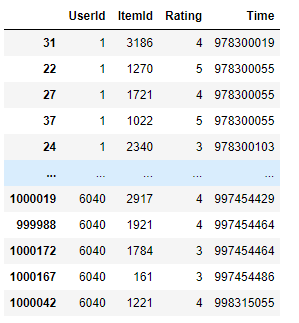

난 처음에 97년도 데이터부터 있는 줄 알았다.
이걸 직관적으로 보기 위해선 년-월-일 개념으로 다시 바꿔줄 필요가 있었다.

`data['Time'] = pd.to_datetime(data['Time'], unit='s')` 를 통해 바꾸었다.

2. 모델 변경 - GRU layer 증가
GRU 가 정확히 무슨 layer인지 이해가 부족했다. 

> GRU ; Gated Recuurent Unit.  

GRU는 LSTM 과 비슷한 역할을 하지만 더 간단한 구조로 되어 있다.  
GRU 에는 LSTM 의 `cell` 이 없는 대신 출력 `h`에서 그 역할을 함께 수행한다.

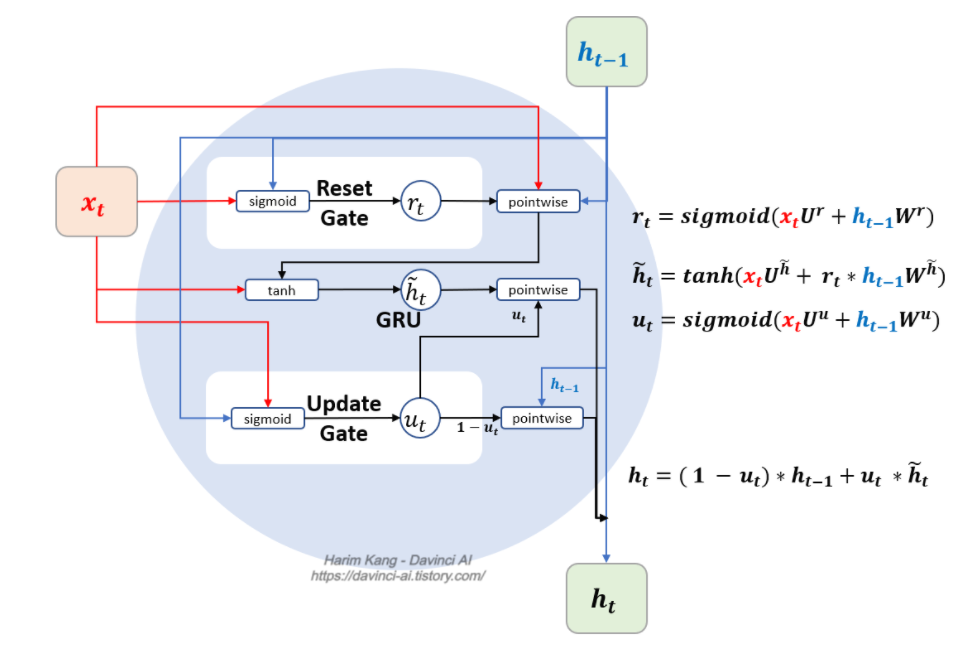

전체적인 작동원리는 알았다. 그런데, 내가 이 layer를 쓰기 위해선  
결과적으로 어떤 input이 들어가서 어떤 output 이 나오는지 알아야 했다.

그래서 tensorflow 홈페이지에서 GRU 메서드에 대한 설명을 찾아봤다.

그 과정에서, `return_state` 라는 파라미터는 마지막 state 를 반환함을 알았다.  
그리고 GRU 모델 구조를 살펴보면서 3차원의 데이터가 2차원으로 축소함을 알았다.  

그렇다면 다시 GRU 모델을 쓰고싶다면 그 2차원의 데이터를 3차원으로 증가시켜야겠지? 
그래서 배열 차원을 억지로 증가시킬 수 있는 array 메서드를 찾아 보았다.

그래서 찾은 메서드가 `np.newaxis`

이걸 통해 중간에 차원을 증가시켜서 GRU 가 여러번 돌아갈 수 있도록 바꿔주었다.


## 3-3. 추후

NLP 분야를 Going Deeper 할 예정이니만큼 순환 신경망에 대해 좀 더 확실하게 짚고 넘어가겠습니다.